In [0]:
# Import Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Transformations
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-20.0, 20.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
#Dataset and Creating Train/Test Split
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
#Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
#Model Building 
# Build the neural network, expand on top of nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution block-1
        self.conv_blk1 = nn.Sequential(
            # input layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0,  bias=False),   
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        # Transition Layer for Convolution block-1
        self.conv_blk1_transition = nn.Sequential(
            nn.MaxPool2d(2, 2),                                                                     
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0,  bias=False)
         )

        # Convolution block-2
        self.conv_blk2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        # Output Block
        self.output_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),                                                             
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0,  bias=False),  
            # no ReLU for last covv layer
            # No Batch Normalization
        ) # output_size = 1

    def forward(self, x):

        x = self.conv_blk1(x) 
        x = self.conv_blk1_transition(x)
        x = self.conv_blk2(x) 
        x = self.output_block(x)  
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [8]:
# Model Parameters

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
#Training and Testing

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
#train_epoch_end = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss=0
    for param in model.parameters():
      zero_vector = torch.rand_like(param)*0
      reg_loss += l1_crit(param, zero_vector)
    factor = 0.0005
    loss += factor*reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)      

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.39101386070251465 Batch_id=468 Accuracy=93.15: 100%|██████████| 469/469 [00:14<00:00, 39.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0961, Accuracy: 9708/10000 (97.08%)

EPOCH: 1


Loss=0.357993483543396 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9691/10000 (96.91%)

EPOCH: 2


Loss=0.3419259786605835 Batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:14<00:00, 36.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0853, Accuracy: 9785/10000 (97.85%)

EPOCH: 3


Loss=0.2969993054866791 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9767/10000 (97.67%)

EPOCH: 4


Loss=0.2784651517868042 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1027, Accuracy: 9711/10000 (97.11%)

EPOCH: 5


Loss=0.26889312267303467 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1146, Accuracy: 9634/10000 (96.34%)

EPOCH: 6


Loss=0.23574233055114746 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1090, Accuracy: 9668/10000 (96.68%)

EPOCH: 7


Loss=0.29971522092819214 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0960, Accuracy: 9689/10000 (96.89%)

EPOCH: 8


Loss=0.27705785632133484 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:14<00:00, 40.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1292, Accuracy: 9611/10000 (96.11%)

EPOCH: 9


Loss=0.3356078863143921 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:15<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9716/10000 (97.16%)

EPOCH: 10


Loss=0.31334614753723145 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0922, Accuracy: 9720/10000 (97.20%)

EPOCH: 11


Loss=0.32209205627441406 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:14<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1004, Accuracy: 9724/10000 (97.24%)

EPOCH: 12


Loss=0.2638120949268341 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9756/10000 (97.56%)

EPOCH: 13


Loss=0.18995614349842072 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0975, Accuracy: 9726/10000 (97.26%)

EPOCH: 14


Loss=0.3873375952243805 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1056, Accuracy: 9691/10000 (96.91%)

EPOCH: 15


Loss=0.30328279733657837 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9788/10000 (97.88%)

EPOCH: 16


Loss=0.2207544445991516 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9776/10000 (97.76%)

EPOCH: 17


Loss=0.2761290669441223 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0620, Accuracy: 9826/10000 (98.26%)

EPOCH: 18


Loss=0.2663228511810303 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 9764/10000 (97.64%)

EPOCH: 19


Loss=0.2721390724182129 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1134, Accuracy: 9671/10000 (96.71%)

EPOCH: 20


Loss=0.40351617336273193 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:19<00:00, 37.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1385, Accuracy: 9592/10000 (95.92%)

EPOCH: 21


Loss=0.24598702788352966 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9812/10000 (98.12%)

EPOCH: 22


Loss=0.26285672187805176 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9764/10000 (97.64%)

EPOCH: 23


Loss=0.31177306175231934 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Accuracy: 9774/10000 (97.74%)

EPOCH: 24


Loss=0.35382673144340515 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1012, Accuracy: 9700/10000 (97.00%)

EPOCH: 25


Loss=0.23362137377262115 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1199, Accuracy: 9639/10000 (96.39%)

EPOCH: 26


Loss=0.2358122318983078 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:15<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0965, Accuracy: 9695/10000 (96.95%)

EPOCH: 27


Loss=0.2501697242259979 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 9685/10000 (96.85%)

EPOCH: 28


Loss=0.27758288383483887 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Accuracy: 9674/10000 (96.74%)

EPOCH: 29


Loss=0.2108660638332367 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:15<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9789/10000 (97.89%)

EPOCH: 30


Loss=0.2558387219905853 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9777/10000 (97.77%)

EPOCH: 31


Loss=0.30357494950294495 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Accuracy: 9765/10000 (97.65%)

EPOCH: 32


Loss=0.2318079173564911 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9812/10000 (98.12%)

EPOCH: 33


Loss=0.25881245732307434 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1281, Accuracy: 9602/10000 (96.02%)

EPOCH: 34


Loss=0.2745082378387451 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0958, Accuracy: 9726/10000 (97.26%)

EPOCH: 35


Loss=0.1824595332145691 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1120, Accuracy: 9649/10000 (96.49%)

EPOCH: 36


Loss=0.2625306248664856 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9721/10000 (97.21%)

EPOCH: 37


Loss=0.2587343752384186 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0979, Accuracy: 9722/10000 (97.22%)

EPOCH: 38


Loss=0.29279059171676636 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1220, Accuracy: 9616/10000 (96.16%)

EPOCH: 39


Loss=0.20794883370399475 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]



Test set: Average loss: 0.0838, Accuracy: 9751/10000 (97.51%)



Text(0, 0.5, 'Accuracy')

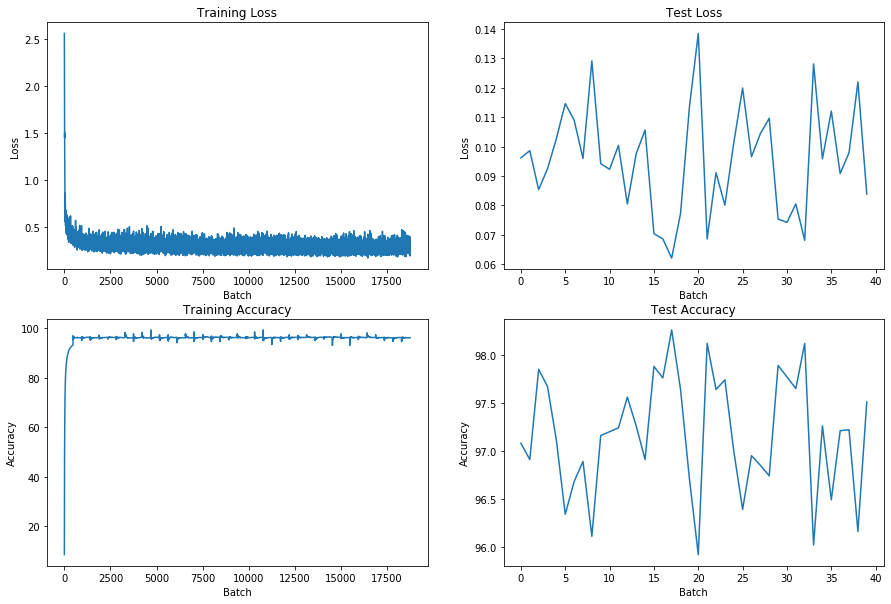

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_xlabel("Batch")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Batch")
axs[1, 0].set_ylabel("Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel("Batch")
axs[0, 1].set_ylabel("Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel("Batch")
axs[1, 1].set_ylabel("Accuracy")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


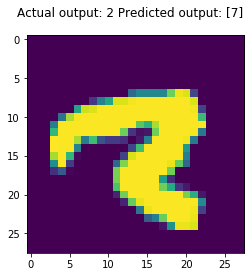

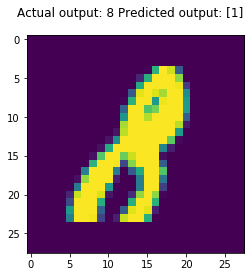

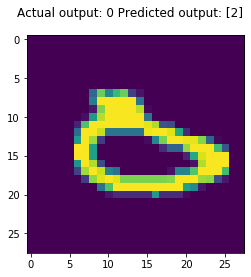

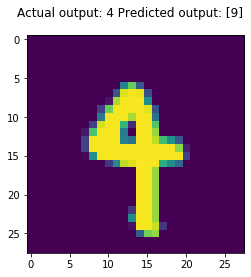

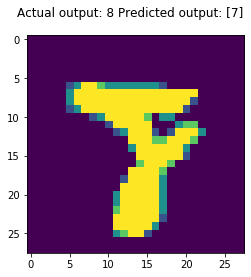

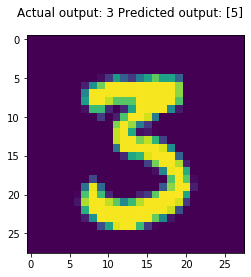

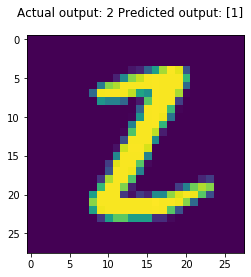

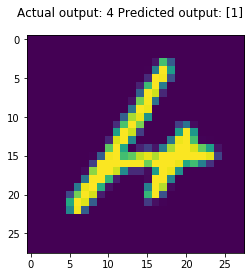

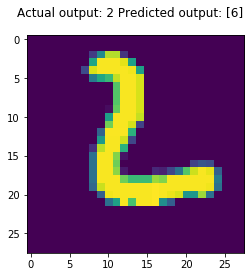

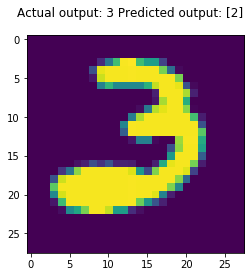

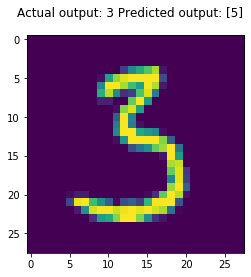

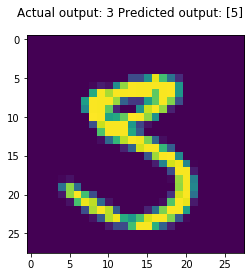

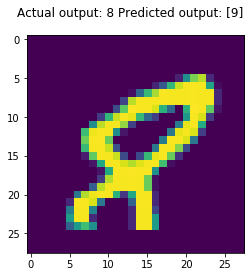

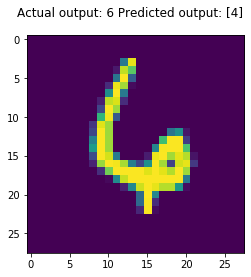

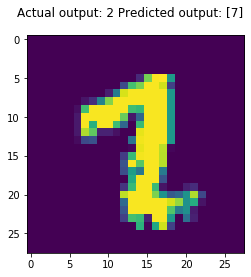

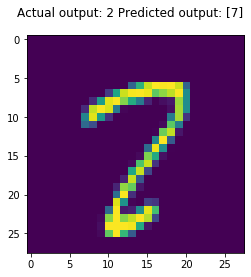

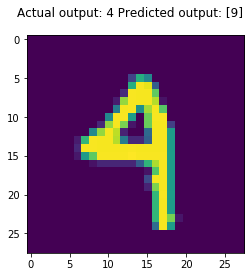

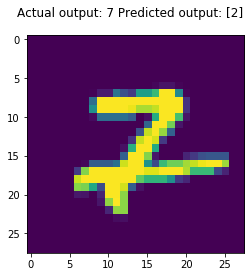

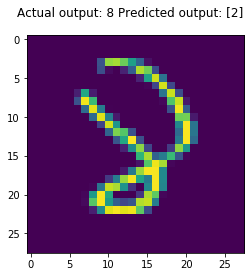

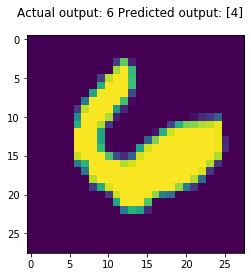

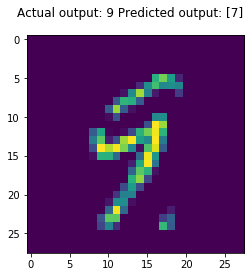

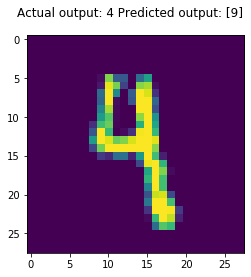

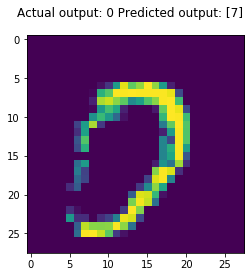

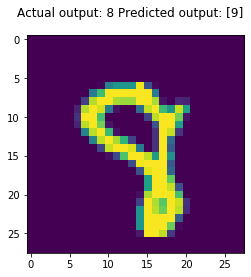

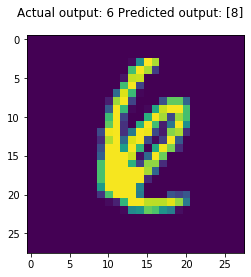

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig(str(count)+".jpg")
                files.download(str(count)+".jpg")
                count = count+1